In [1]:
import imageio
import gymnasium as gym
import numpy as np
import mediapy as media
import torch
# from act.policy import ACTPolicy
import gym_lite6.env, gym_lite6.scripted_policy
import mujoco

pygame 2.2.0 (SDL 2.30.2, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
scene_path = "models/cube_pickup.xml"
model = mujoco.MjModel.from_xml_path(scene_path)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)


""

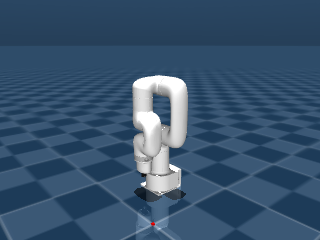

In [3]:

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1.2
camera.elevation = -15
camera.azimuth = -130
camera.lookat = (0, 0, 0.3)

mujoco.mj_forward(model, data)

renderer.update_scene(data, camera)
media.show_image(renderer.render())


In [4]:
DURATION = 4          # seconds
FRAMERATE = 60        # Hz
frames = []
x0 = np.array([1.546, 0.541, 1.49 , 2.961, 0.596, 0.203])
mujoco.mj_resetData(model, data)
qpos = x0
data.qpos[:6] = qpos

while data.time < DURATION:
  # Move the target
  # pos, quat = pose(data.time, speed=1)

  data.ctrl[:6] = qpos
  # print(data.qpos)

  # data.qpos = 0.001
  if data.time < DURATION / 2:
    data.ctrl[6] = 30
  else:
    data.ctrl[6] = -30

  # mujoco.mj_camlight(model, data)
  mujoco.mj_step(model, data)
  # print(data.qfrc_actuator, data.qfrc_applied)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera)
    frames.append(renderer.render())
  
  qpos[0] -= 0.001

media.show_video(frames, loop=False)

,,,,,

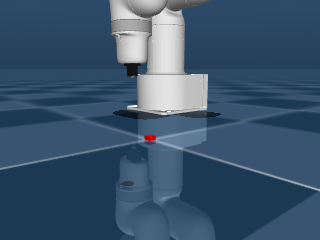
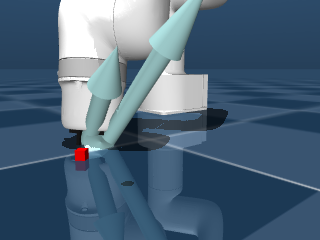
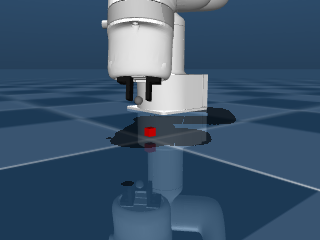
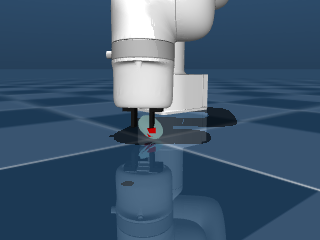
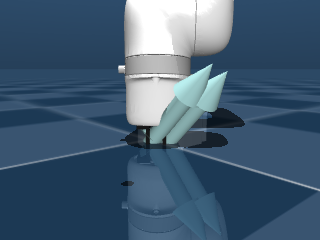
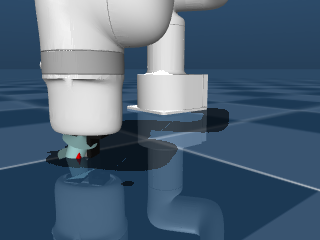

AssertionError: Reward is 2, contacts: [[19 18]]

In [5]:
class PickupTask(object):
    def __init__(self, l_gripper_name, r_gripper_name, box_name, floor_name) -> None:
        """
        geom ids
        """
        self.l_gripper_name = l_gripper_name
        self.r_gripper_name = r_gripper_name
        self.box_name = box_name
        self.floor_name = floor_name
        self.max_reward = 5
    
    def get_reward(self, model, data):
        """
        1 - close to box and not touching ground
        2 - one gripper touching box and not touching ground
        3 - two grippers touching box and not touching ground
        4 - two grippers touching box and box not touching ground
        5 - two grippers touching box and box > 0.2 in z
        """

        l_gripper_touching_ground = False
        r_gripper_touching_ground = False
        box_touching_ground = False
        l_gripper_touching_box = False
        r_gripper_touching_box = False

        for geom in data.contact.geom:
            if all(np.isin(geom, [model.geom(self.floor_name).id, model.geom(self.l_gripper_name).id])):
              l_gripper_touching_ground = True
            
            if all(np.isin(geom, [model.geom(self.floor_name).id, model.geom(self.r_gripper_name).id])):
              r_gripper_touching_ground = True
                        
            if all(np.isin(geom, [model.geom(self.floor_name).id, model.geom(self.box_name).id])):
              box_touching_ground = True
            

            if all(np.isin(geom, [model.geom(self.box_name).id, model.geom(self.l_gripper_name).id])):
              l_gripper_touching_box = True
            if all(np.isin(geom, [model.geom(self.box_name).id,  model.geom(self.r_gripper_name).id])):
              r_gripper_touching_box = True
        
        gripper_touching_ground = l_gripper_touching_ground or r_gripper_touching_ground
        close_to_box = np.linalg.norm(data.body(self.l_gripper_name).xpos - data.body(self.box_name).xpos) < 0.07
        box_above_height = data.body(self.box_name).xpos[2] > 0.2

        # print(f"gripper_touching_ground: {gripper_touching_ground}, box_touching_ground: {box_touching_ground}, l_gripper_touching_box: {l_gripper_touching_box}, r_gripper_touching_box: {r_gripper_touching_box}, close_to_box: {close_to_box}, box_above_height: {box_above_height}")

        reward = 0
        if l_gripper_touching_box and r_gripper_touching_box and box_above_height:
            assert(not box_touching_ground)
            assert(not gripper_touching_ground)
            assert(close_to_box)
            reward = 5
        elif l_gripper_touching_box and r_gripper_touching_box and not box_touching_ground and not gripper_touching_ground:
            assert(close_to_box)
            reward = 4
        elif l_gripper_touching_box and r_gripper_touching_box and not gripper_touching_ground:
            assert(close_to_box)
            reward = 3
        elif l_gripper_touching_box or r_gripper_touching_box and not gripper_touching_ground:
            assert(close_to_box)
            reward = 2
        elif close_to_box and not gripper_touching_ground:
            reward = 1
        
        return reward
  
task = PickupTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')

camera.distance = 0.5
camera.elevation = -10
# camera.azimuth = -130
camera.lookat = (0.1, 0.1, 0)

voption = mujoco.MjvOption()
voption.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = False
voption.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

f = []
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption); f.append(renderer.render())
reward = task.get_reward(model, data)
assert reward == 0, f"Reward is {reward}, contacts: {data.contact}"

# Gripper touching ground near cube
data.qpos = np.array([0.57, 1.04, 1.2, -0.00014, 0.00034, 5.1e-05, -0.0086, 0.0083, 0.3, 0.22, 0.005, 0.65, -0.65, 0.28, -0.28])
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption); f.append(renderer.render())
reward = task.get_reward(model, data)
assert reward == 0, f"Reward is {reward}, contacts: {data.contact}"

# Close to box
data.qpos = np.array([0.75, 0.73, 0.96, -0.00021, 0.00023, -1.4e-06, -0.0095, 0.0086, 0.2, 0.2, 0.01, 1, -1.7e-06, 1.8e-06, -0.0023])
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption); f.append(renderer.render())
reward = task.get_reward(model, data)
assert reward == 1, f"Reward is {reward}, contacts: {data.contact}"

# One gripper touching box
data.qpos = np.array([0.75, 0.86, 0.97, -0.00027, 0.0029, -0.00015, -0.0096, 0.0087, 0.2, 0.2, 0.01, 1, -3.5e-05, -6.1e-05, -0.0039])
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption); f.append(renderer.render())
reward = task.get_reward(model, data)
assert reward == 2, f"Reward is {reward}, contacts: {data.contact}"

# Two grippers touching box but also touching ground
data.qpos = np.array([0.82, 0.981, 1.1, -0.00012, -1.6e-05, 1.6e-05, -0.0066, 0.0085, 0.2, 0.21, 0.005, 0.71, -0.71, 0.052, -0.052])
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption); f.append(renderer.render())
reward = task.get_reward(model, data)
assert reward == 0, f"Reward is {reward}, contacts: {data.contact.geom}"

## Seems to be an issue with feeding qpos in and getting contact with both grippers

# Two grippers touching box and box on ground
data.qpos = np.array([0.63, 1.19, 1.6, -0.0004, 0.39, -5.6e-07, -0.0049, 0.0051, 0.3, 0.21, 0.005, 0.63, -0.63, 0.32, -0.32])
# data.ctrl = np.array([0.63, 1.2, 1.7, 0, 0.39, 0, 1.5])
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera, voption); f.append(renderer.render())
reward = task.get_reward(model, data)
media.show_images(f)
assert reward == 3, f"Reward is {reward}, contacts: {data.contact.geom}"

# data.qpos = np.array([0.82, 1, 1.2, -0.00022, 0.00026, -4.4e-06, -0.0043, 0.0062, 0.22, 0.23, 0.013, 0.69, -0.65, 0.21, -0.23])
# mujoco.mj_forward(model, data)
# renderer.update_scene(data, camera, voption); f.append(renderer.render())
# reward = task.get_reward(model, data)
# assert reward == 4, f"Reward is {reward}, contacts: {data.contact}"

# # Lifted
# data.qpos = np.array([0.82, 0.42, 1.2, -0.00068, 0.00086, -1.4e-06, -0.004, 0.006, 0.27, 0.29, 0.23, 0.82, -0.44, 0.17, -0.32])
# mujoco.mj_forward(model, data)
# camera.lookat = (0.1, 0.1, 0.2)
# renderer.update_scene(data, camera, voption); f.append(renderer.render())
# reward = task.get_reward(model, data)
# assert reward == 4, f"Reward is {reward}, contacts: {data.contact}"




""

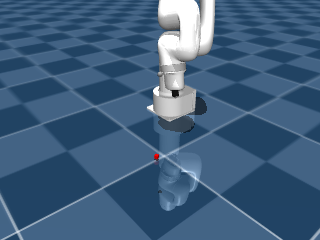

In [30]:
from importlib import reload

reload(gym_lite6.env)
reload(gym_lite6.utils)
reload(gym_lite6.scripted_policy)
env = gym.make(
    "UfactoryCubePickup-v0",
    task=task,
    obs_type="pixels_state",
    max_episode_steps=300,
)
observation, info = env.reset()
media.show_image(env.render())


In [28]:
# Run a scripted rollout

policy = gym_lite6.scripted_policy.ScriptedPickupPolicy(env, 'end_effector', 'box', 'gripper_left_finger', 'gripper_right_finger', max_vel=0.2)

# Reset the policy and environmens to prepare for rollout
policy.reset()
observation, info = env.reset(seed=69)

# Prepare to collect every rewards and all the frames of the episode,
# from initial state to final state.
# rewards = []
frames = []

# Render frame of the initial state
frames.append(env.render())


step = 0
done = False
while not done and len(frames) < 500:

    # Predict the next action with respect to the current observation
    action = policy(env.unwrapped.model, env.unwrapped.data, observation, info)

    # Step through the environment and receive a new observation
    observation, reward, terminated, truncated, info = env.step(action)

    if (policy.stage == 4):
        truncated = True
    print(f"{step=} {reward=} {terminated=}")

    frames.append(env.render())

    # The rollout is considered done when the success state is reach (i.e. terminated is True),
    # or the maximum number of iterations is reached (i.e. truncated is True)
    done = terminated | truncated | done
    step += 1

if terminated:
    print("Success!")
else:
    print("Failure!")

media.show_video(frames, fps=env.metadata["render_fps"])

/Users/Eugene/miniconda3/envs/lerobot/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


{0: {'start_time': 0.0, 'end_time': 4.156842014434082, 'T_start': array([[-0.35928864, -0.63339311,  0.68536475,  0.33975658],
       [-0.39921078, -0.55950195, -0.72635275, -0.1369503 ],
       [ 0.84352974, -0.53457529, -0.05183466,  0.37297119],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.10781155],
       [ 0.        , -1.        ,  0.        , -0.05834567],
       [ 0.        ,  0.        , -1.        ,  0.0235    ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.10781155, -0.05834567,  0.0235    ]), 'goal_quat': array([0, 1, 0, 0])}}
step=0 reward=0 terminated=False
step=1 reward=0 terminated=False
step=2 reward=0 terminated=False
step=3 reward=0 terminated=False
step=4 reward=0 terminated=False
step=5 reward=0 terminated=False
step=6 reward=0 terminated=False
step=7 reward=0 terminated=False
step=8 reward=0 terminated=False
step=9 reward=0 terminated=False
step=10 

In [8]:
import h5py
from pathlib import Path
import os

def create_h5py_dataset(data_dict, group):
  for key, val in data_dict.items():
    if isinstance(val, dict):
      grp = group.create_group(key)
      create_h5py_dataset(data_dict[key], grp)
    elif isinstance(val, list):
      group.create_dataset(key, data=val)

def record_episodes(env, policy, dataset_dir, n=1, len=300):

  if not os.path.isdir(dataset_dir):
    os.makedirs(dataset_dir, exist_ok=True)

  successful_trajectories = 0

  while successful_trajectories < n:
    episode_idx = successful_trajectories
    print(f"Episode {episode_idx}")
    observation, info = env.reset()
    policy.reset()

    data = {"action": {"qpos": [], "gripper": []}, "observation": {"state": {"qpos": [], "gripper": []}, "pixels": []}, "reward": []}
    for step in range(len):
      action = policy(env.unwrapped.model, env.unwrapped.data, observation, info)
      observation, reward, terminated, truncated, info = env.step(action)

      # action = {"qpos": step, "gripper": 0}
      # observation = {"qpos": step, "gripper": 1}
      # reward = 2
      # print(observation)
      # print(data)
      data["action"]["qpos"].append(action["qpos"])
      data["action"]["gripper"].append(action["gripper"])
      data["observation"]["state"]["qpos"].append(observation["state"]["qpos"])
      data["observation"]["state"]["gripper"].append(observation["state"]["gripper"])
      data["observation"]["pixels"].append(observation["pixels"])
      data["reward"].append(reward)
    
    if policy.stage == 4:
      path = Path(dataset_dir)/f"ep_{episode_idx}.hdf5"
      with h5py.File(path, "w") as f:
        create_h5py_dataset(data, f)
      successful_trajectories += 1
      media.write_video(path + ".mp4", data["observation"]["pixels"], fps=env.metadata["render_fps"])
      print(f"Success, saved {path}")
    else:
      print("Failed, retrying")

    media.show_video(data["observation"]["pixels"])

    

In [ ]:
policy = gym_lite6.scripted_policy.ScriptedPickupPolicy(env, 'end_effector', 'box', 'gripper_left_finger', 'gripper_right_finger', max_vel=0.2)
record_episodes(env, policy, "dataset/pickup/", n=50)


In [ ]:

device = torch.device("mps")

# policy = ACTPolicy.from_pretrained(pretrained_policy_path)
# policy.eval()
# policy.to(device)
policy = gym_lite6.scripted_policy.ScriptedPickupPolicy(env, 'end_effector', 'box', 'gripper_left_finger', 'gripper_right_finger', max_vel=0.2)

# Reset the policy and environmens to prepare for rollout
# policy.reset()
numpy_observation, info = env.reset(seed=69)

# Prepare to collect every rewards and all the frames of the episode,
# from initial state to final state.
rewards = []
frames = []

# Render frame of the initial state
frames.append(env.render())


step = 0
done = False
while not done and len(frames) < 500:
# while not done:
    # Prepare observation for the policy running in Pytorch
    # Get qpos in range (-1, 1), gripper is already in range (-1, 1)
    qpos_normalised = env.unwrapped.normalize_qpos(numpy_observation["state"]["qpos"])
    state = torch.from_numpy(np.hstack((qpos_normalised, numpy_observation["state"]["gripper"])))
    image = torch.from_numpy(numpy_observation["pixels"])

    # Convert to float32 with image from channel first in [0,255]
    # to channel last in [0,1]
    state = state.to(torch.float32)
    image = image.to(torch.float32) / 255
    image = image.permute(2, 0, 1)

    # Send data tensors from CPU to GPU
    state = state.to(device, non_blocking=True)
    image = image.to(device, non_blocking=True)

    # Add extra (empty) batch dimension, required to forward the policy
    state = state.unsqueeze(0)
    image = image.unsqueeze(0)

    # Create the policy input dictionary
    observation = {
        "observation.state": state,
        "observation.images.top": image,
    }

    # Predict the next action with respect to the current observation
    with torch.inference_mode():
        action = policy(env.unwrapped.model, env.unwrapped.data, numpy_observation, info)
        # action = {"gripper": 0, "qpos": np.array([0.785, 0.289, 1.109, 0.,    0.82,  0.785])}
        # action = env.action_space.sample()
        # print(action, env.data.time)

    # Prepare the action for the environment
    # unnormalize_qpos
    # numpy_action = action.to("cpu").numpy()
    # numpy_action = np.hstack((action["qpos"], action["gripper"]))

    # Step through the environment and receive a new observation
    numpy_observation, reward, terminated, truncated, info = env.step(action)

    if (policy.stage == 4):
        truncated = True
    print(f"{step=} {reward=} {terminated=}")

    # Keep track of all the rewards and frames
    rewards.append(reward)
    # if len(frames) < env.data.time * env.metadata["render_fps"]:
      # print("append", data.time)
    frames.append(env.render())

    # The rollout is considered done when the success state is reach (i.e. terminated is True),
    # or the maximum number of iterations is reached (i.e. truncated is True)
    done = terminated | truncated | done
    step += 1

if terminated:
    print("Success!")
else:
    print("Failure!")

media.show_video(frames, fps=env.metadata["render_fps"])

In [17]:
data.body()

KeyError: "Invalid name ''. Valid names: ['box', 'gripper_body', 'gripper_left_finger', 'gripper_right_finger', 'link1', 'link2', 'link3', 'link4', 'link5', 'link6', 'link_base', 'target', 'world']"